In [5]:
!pip install --upgrade tensorflow matplotlib seaborn

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
# Paths
model_path = '/content/drive/MyDrive/Classifier/real_only_model.h5'
merged_dataset_dir = '/content/drive/MyDrive/Classification_datset_gravity_spy'
img_dim = 250

# Load saved model
model = load_model(model_path)
print("Model loaded.")

# Load merged (real + GAN) dataset
eval_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = eval_datagen.flow_from_directory(
    merged_dataset_dir,
    target_size=(img_dim, img_dim),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_true = eval_generator.classes
class_names = list(eval_generator.class_indices.keys())


Model loaded.
Found 20823 images belonging to 22 classes.


In [16]:
predictions = model.predict(eval_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
max_confidences = np.max(predictions, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20823/20823 ━━━━━━━━━━━━━━━━━━━━ 486s 23ms/step


In [18]:
import numpy as np

valid_mask = y_pred < len(class_names)  # Only keep predictions < 21

y_true_filtered = y_true[valid_mask]
y_pred_filtered = y_pred[valid_mask]

print(f" Filtered {len(y_true) - len(y_true_filtered)} invalid predictions.")


 Filtered 0 invalid predictions.


 Detection Efficiency (Recall per Class):
                  Class  Detection Efficiency (Recall)
0             1080Lines                       0.979167
1           1400Ripples                       0.911111
2        Air_Compressor                       0.966418
3                  Blip                       0.980411
4                 Chirp                       0.957143
5        Extremely_Loud                       0.915605
6                 Helix                       0.995719
7              Koi_Fish                       0.982244
8      Light_Modulation                       0.945884
9   Low_Frequency_Burst                       0.906618
10  Low_Frequency_Lines                       0.842563
11            No_Glitch                       0.822674
12    None_of_the_Above                       0.416667
13         Paired_Doves                       0.225806
14           Power_Line                       0.995283
15      Repeating_Blips                       0.837108
16      Scattered_Light

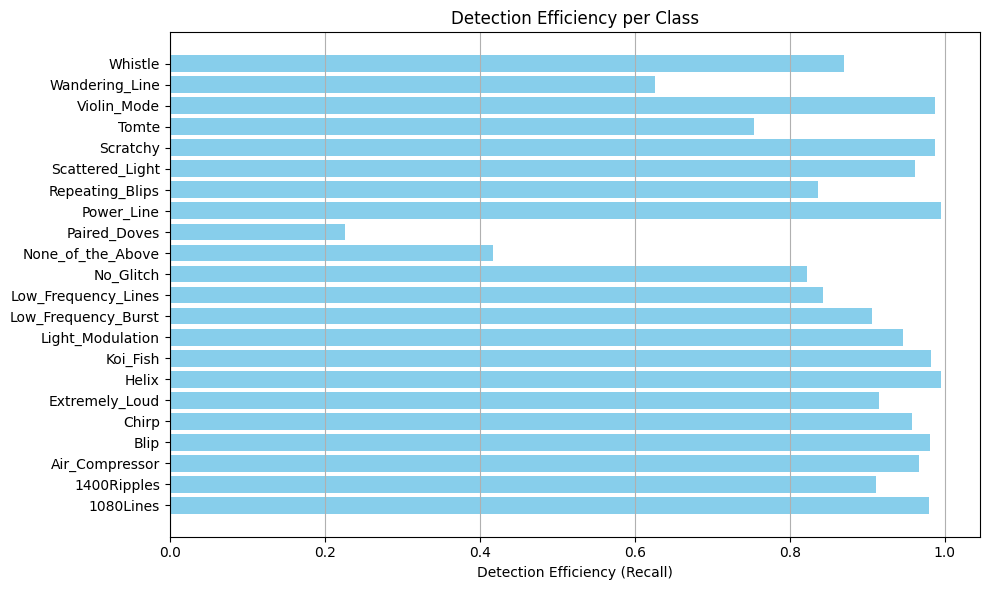

In [25]:
from sklearn.metrics import classification_report
import pandas as pd

# Get classification report as dict
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Extract per-class recall (detection efficiency)
efficiency_df = pd.DataFrame({
    "Class": list(report.keys())[:-3],  # ignore avg/total rows
    "Detection Efficiency (Recall)": [report[c]['recall'] for c in class_names]
})

print(" Detection Efficiency (Recall per Class):")
print(efficiency_df)

# Bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(efficiency_df["Class"], efficiency_df["Detection Efficiency (Recall)"], color='skyblue')
plt.xlabel("Detection Efficiency (Recall)")
plt.title("Detection Efficiency per Class")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [27]:
acc = accuracy_score(y_true, y_pred)
print(f" Accuracy on real + GAN data: {acc:.4f}")

 Accuracy on real + GAN data: 0.9272


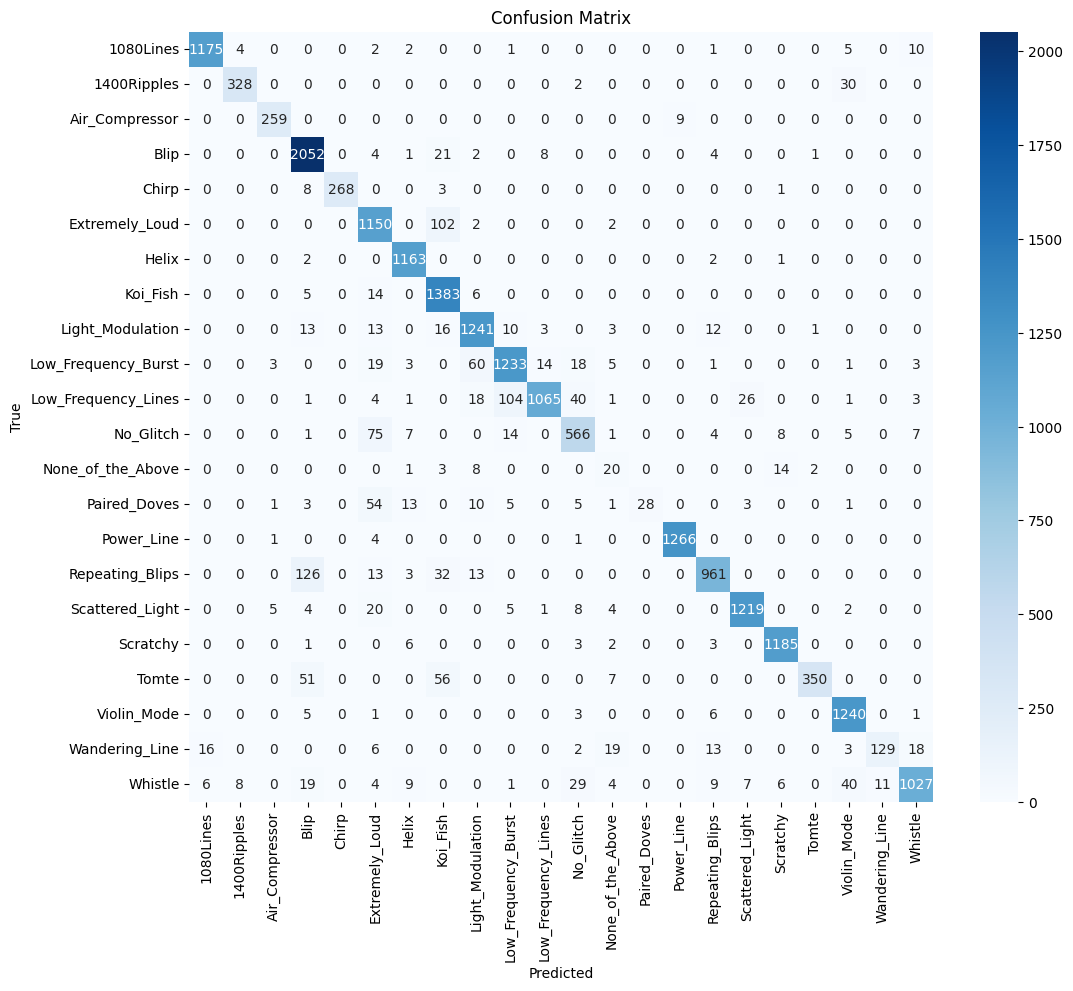

In [26]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [22]:
threshold = 0.85
confident_mask = max_confidences >= threshold

confident_y_true = y_true[confident_mask]
confident_y_pred = y_pred[confident_mask]

print(f" Confident predictions: {len(confident_y_true)} / {len(y_true)}")
print(f" Accuracy on confident subset: {accuracy_score(confident_y_true, confident_y_pred):.4f}")


 Confident predictions: 16868 / 20823
 Accuracy on confident subset: 0.9771
